# Predciting lising gains in the Indian IPO market using TensorFLow

# Table of contents

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import legend

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Introduction
The goal of any machine learning and deep learning is to help pull out insights about the data that a human simply
would not be able to notice, and to avoid any initial bias humans would have about the data. Using those insights to
predict some small segment of the future with reasonable accuracy, should lead to better outcomes. One application of
that is forecasting the percentage difference between the Initial Public Offering (IPO) price and the end of day
trading price. Referred to as the listing gain.

Being able to effectively forecast if the listing gains for an IPO are positive or negative and how much, allows a
savvy investor to invest in companies that are going to increase in value and avoid or short those that will decrease
 in value.

The data we'll be using comes from https://www.moneycontrol.com/ipo/ipo-historic-table?classic=true


# Data exploration

## Data structure
| **Column Name**         | **Description**                                                                                       |
|-------------------------|-------------------------------------------------------------------------------------------------------|
| `Date`                  | Date when the IPO was listed                                                                          |
| `IPOName`               | Name of the IPO                                                                                       |
| `Issue_Size`            | Size of the IPO issue, in INR Crores                                                                  |
| `Subscription_QIB`      | Number of times the IPO was subscribed by the QIB (Qualified Institutional Buyer) investor category   |
| `Subscription_HNI`      | Number of times the IPO was subscribed by the HNI (High Networth Individual) investor category        |
| `Subscription_RII`      | Number of times the IPO was subscribed by the RII (Retail Individual Investors) investor category     |
| `Subscription_Total`    | Total number of times the IPO was subscribed overall                                                  |
| `Issue_Price`           | The price in INR at which the IPO was issued                                                          |
| `Listing_Gains_Percent` | The percentage gain in the listing price over the issue price                                         |

The data fields are primarily the `Date`, `Issue_Size`, `Issue_Price`, `Subscription_Total` and
`Listing_Gains_Percent` as our target we're trying to predict. The split of the `Subscription_Total` into `QIB`,
`HNI`, `RII` means we're probably getting some redundant data. It may aid in the speed of training the neural
network, or hinder it. The `IPOName` is just an identifier, it may be possible to extract from the name of the IPO
the words and assign some kind of numerical score in different categories based upon the type of industry or
technology, but we'll start with a simpler model.



In [3]:
ipo_data = pd.read_csv('Indian_IPO_Market_Data.csv')
ipo_data.shape

(319, 9)

In [4]:
print(ipo_data.head(5))

      Date           IPOName  Issue_Size  Subscription_QIB  Subscription_HNI  \
0  03/02/10    Infinite Comp      189.80             48.44            106.02   
1  08/02/10    Jubilant Food      328.70             59.39             51.95   
2  15/02/10    Syncom Health       56.25              0.99             16.60   
3  15/02/10  Vascon Engineer      199.80              1.12              3.65   
4  19/02/10      Thangamayil        0.00              0.52              1.52   

   Subscription_RII  Subscription_Total  Issue_Price  Listing_Gains_Percent  
0             11.08               43.22          165                  11.82  
1              3.79               31.11          145                 -84.21  
2              6.25                5.17           75                  17.13  
3              0.62                1.22          165                 -11.28  
4              2.26                1.12           75                  -5.20  


In [5]:
print(ipo_data.tail(5))

        Date           IPOName  Issue_Size  Subscription_QIB  \
314  26/08/22        Syrma SGS      840.13             42.42   
315  06/09/22  Dreamfolks Serv      562.10             27.48   
316  15/09/22              TMB      792.00              0.51   
317  26/09/22  Harsha Engineer      755.00            113.82   
318  17/10/22  Electronics Mar      500.00             58.81   

     Subscription_HNI  Subscription_RII  Subscription_Total  Issue_Price  \
314              7.13              2.84               15.59          220   
315             14.18             24.19               23.25          326   
316              1.77              3.44                1.39          525   
317             40.36             12.44               47.19          330   
318             15.39              8.27               24.23           59   

     Listing_Gains_Percent  
314                  42.30  
315                  41.92  
316                  -3.15  
317                  47.24  
318          

In [6]:
print(ipo_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 22.6+ KB
None


In [7]:
import pandas as pd
from IPython.display import display

summary_stats = ipo_data.select_dtypes(include=np.number).describe()
# Format the numbers to XX.YY format and remove trailing zeroes
formatted_summary_stats = summary_stats.map(lambda x: f"{x:.2f}".rstrip('0').rstrip('.'))
display(pd.DataFrame(formatted_summary_stats).style.set_caption("Summary Statistics").set_table_styles(
    [{'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('font-weight', 'bold')]}]
)
)

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319,319,319,319,319,319,319
mean,1192.86,25.68,70.09,8.56,27.45,375.13,4.74
std,2384.64,40.72,142.45,14.51,48.77,353.9,47.65
min,0,0,0,0,0,0,-97.15
25%,169,1.15,1.25,1.27,1.65,119,-11.55
50%,496.25,4.94,5.07,3.42,4.93,250,1.81
75%,1100,34.64,62.09,8.61,33.39,536,25.31
max,21000,215.45,958.07,119.44,326.49,2150,270.4


The data is interesting. There's 319 entries, but clearly some entries may need to be removed since a 0 `issue_price`
and 0 `issue_size` indicates an IPO that didn't really happen (or incomplete data). Need some domain experience to
understand why that may be the case

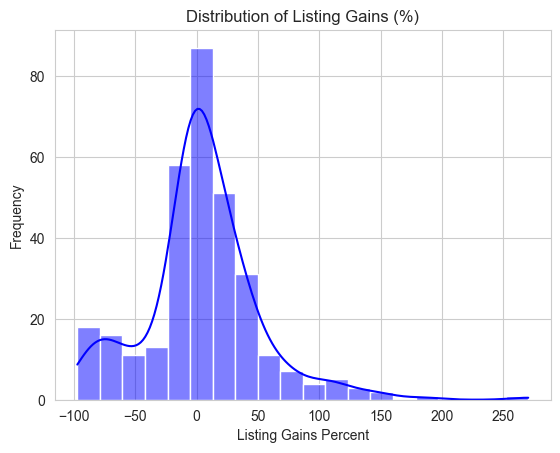

In [8]:
# Plot the distribution of Listing_Gains_Percent
sns.histplot(ipo_data['Listing_Gains_Percent'], kde=True, bins=20, color='blue')
plt.title('Distribution of Listing Gains (%)')
plt.xlabel('Listing Gains Percent')
plt.ylabel('Frequency')
plt.show()

## Feature engineering
We want to be able to train our neural network to identify IPOs with high listing gains, a simple approach would be
just a binary classification as positive or negative, but it may be more informative and useful to create some bins
for the range of performance of the listing gains. Since our model isn't going to be perfect, if we can get higher
accuracy on the moderate to extreme gains and avoid the moderate to extreme losses, we'll make more money.

In [9]:
# Use `qcut` to divide positive "Listing_Gains_Percent" into quantile bins
positive_bins = pd.qcut(
    ipo_data.loc[ipo_data["Listing_Gains_Percent"] > 0, "Listing_Gains_Percent"],
    q=3,
    duplicates="drop",
)

# Use `qcut` to divide negative "Listing_Gains_Percent" into quantile bins
negative_bins = pd.qcut(
    ipo_data.loc[ipo_data["Listing_Gains_Percent"] < 0, "Listing_Gains_Percent"],
    q=3,
    duplicates="drop",
)

# Corrected line to extract the intervals/categories for positive values
positive_categories = positive_bins.cat.categories

# Corrected line to extract the intervals/categories for negative values
negative_categories = negative_bins.cat.categories

# Get the bin edges from the Categorical intervals for positive values
positive_bin_edges = np.unique(
    positive_categories.left.tolist() + positive_categories.right.tolist()
)

# Get the bin edges from the Categorical intervals for negative values
negative_bin_edges = np.unique(
    negative_categories.left.tolist() + negative_categories.right.tolist()
)

print("Positive Categories:", positive_categories)
print("Positive Bin Edges:", positive_bin_edges)
print("Negative Categories:", negative_categories)
print("Negative Bin Edges:", negative_bin_edges)

Positive Categories: IntervalIndex([(0.019, 13.2], (13.2, 34.71], (34.71, 270.4]], dtype='interval[float64, right]')
Positive Bin Edges: [1.900e-02 1.320e+01 3.471e+01 2.704e+02]
Negative Categories: IntervalIndex([(-97.15100000000001, -36.917], (-36.917, -8.49],
               (-8.49, -0.02]],
              dtype='interval[float64, right]')
Negative Bin Edges: [-9.7151e+01 -3.6917e+01 -8.4900e+00 -2.0000e-02]


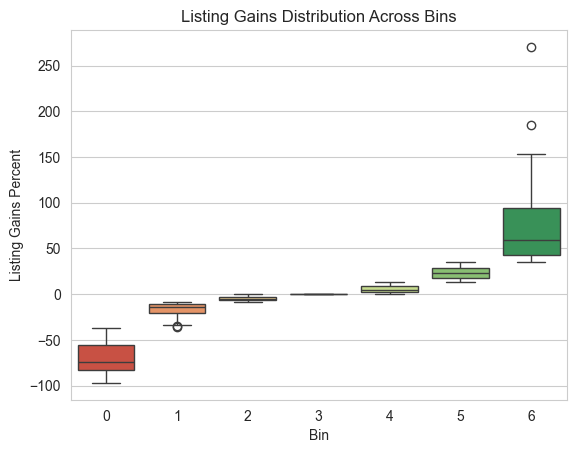

In [10]:
# Define bin edges for plotting
bin_edges = np.concatenate([negative_bin_edges, positive_bin_edges])

# Assign each listing gain to its respective bin
ipo_data["Bin"] = pd.cut(
    ipo_data["Listing_Gains_Percent"],
    bins=bin_edges,
    labels=False,
    include_lowest=True
)

# Plot the listing gains as grouped by bins
sns.boxplot(
    x="Bin",
    y="Listing_Gains_Percent",
    data=ipo_data,
    palette=sns.color_palette("RdYlGn", len(bin_edges) - 1),
    hue="Bin",
    legend=False
)
plt.title('Listing Gains Distribution Across Bins')
plt.xlabel('Bin')
plt.ylabel('Listing Gains Percent')
plt.show()

Now that we've split the listing gains into 7 categories, we have multiple targets to aim for. We definitely want to
avoid 50 to 100% losses, and would prefer to get as many 50 to 250% gains as possible. This may impact on the
training of the neural network. We may not have enough data for this level of granularity.



In [11]:
# Use the bin edges to create a new column that encodes the output of each listing_gain into one of the 7 bins
ipo_data["Listing_Gains_Category"] = pd.cut(
    ipo_data["Listing_Gains_Percent"],
    bins=bin_edges,
    labels=["Extreme Loss", "Moderate Loss", "Minor Loss", "Zero", "Minor Gain", "Moderate Gain", "Extreme Gain"],
    include_lowest=True
)

# Display the first few rows to confirm the new column
print(ipo_data[["Listing_Gains_Percent", "Listing_Gains_Category"]].head())

   Listing_Gains_Percent Listing_Gains_Category
0                  11.82             Minor Gain
1                 -84.21           Extreme Loss
2                  17.13          Moderate Gain
3                 -11.28          Moderate Loss
4                  -5.20             Minor Loss


In [12]:
# Display all rows with 0 `issue_price`
zero_issue_price_rows = ipo_data[ipo_data["Issue_Price"] == 0]
display(zero_issue_price_rows)

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent,Bin,Listing_Gains_Category
202,04/04/18,Mishra Dhatu Ni,438.38,1.96,0.12,0.72,1.21,0,0.0,3,Zero
216,08/05/19,Neogen,131.48,30.49,113.88,16.06,41.18,0,0.0,3,Zero


In [13]:
# Display all rows with 0 `issue_size`
zero_issue_size_rows = ipo_data[ipo_data["Issue_Size"] == 0]
display(zero_issue_size_rows)

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent,Bin,Listing_Gains_Category
4,19/02/10,Thangamayil,0.0,0.52,1.52,2.26,1.12,75,-5.20,2,Minor Loss
41,08/10/10,Electrosteel St,0.0,5.86,28.58,6.19,8.23,11,2.27,4,Minor Gain
102,06/12/12,Tara Jewels,0.0,1.49,3.10,2.05,1.98,230,-0.02,2,Minor Loss
282,15/11/21,Sigachi Ind,0.0,42.15,78.82,41.26,49.56,163,270.40,6,Extreme Gain


In [14]:
# Display all rows with a listing gains category of "Zero"
zero_category_rows = ipo_data[ipo_data["Listing_Gains_Category"] == "Zero"]
display(zero_category_rows)

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent,Bin,Listing_Gains_Category
202,04/04/18,Mishra Dhatu Ni,438.38,1.96,0.12,0.72,1.21,0,0.0,3,Zero
216,08/05/19,Neogen,131.48,30.49,113.88,16.06,41.18,0,0.0,3,Zero


In [15]:
# Display all rows with a listing gains category of "Extreme Gain"
extreme_gain_rows = ipo_data[ipo_data["Listing_Gains_Category"] == "Extreme Gain"]
display(extreme_gain_rows)

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent,Bin,Listing_Gains_Category
9,03/03/10,ARSS Infra,103.00,49.34,124.53,18.55,47.62,450,63.62,6,Extreme Gain
10,10/03/10,Texmo Pipes,45.00,1.02,30.50,7.26,7.48,90,52.50,6,Extreme Gain
13,29/03/10,DQ Entertain,128.38,93.86,272.88,19.45,86.33,80,35.69,6,Extreme Gain
29,28/07/10,Shri Aster,53.10,0.01,12.46,7.41,4.47,118,68.73,6,Extreme Gain
38,06/10/10,Career Point,115.00,47.45,101.93,31.74,47.39,310,103.98,6,Extreme Gain
47,14/10/10,Bedmutha Ind,91.80,0.67,29.19,8.51,7.69,102,77.25,6,Extreme Gain
53,04/11/10,Coal India,15475.00,24.70,25.40,2.31,15.28,245,39.73,6,Extreme Gain
64,11/03/11,Sudar Ind,69.98,0.17,4.47,2.27,1.55,77,46.88,6,Extreme Gain
76,22/06/11,Timbor Home,23.25,0.65,3.22,14.22,5.78,63,44.76,6,Extreme Gain
77,07/07/11,Birla Pacific,65.18,1.04,0.17,1.82,1.18,10,153.50,6,Extreme Gain


In [16]:
# Display the value counts of each listing gains category
listing_gain_counts = ipo_data["Listing_Gains_Category"].value_counts()
print(listing_gain_counts)

Listing_Gains_Category
Extreme Gain     58
Moderate Gain    58
Minor Gain       58
Extreme Loss     48
Minor Loss       48
Moderate Loss    47
Zero              2
Name: count, dtype: int64


## Listing Gain Category
With the bins as decribed, we're getting 176 positive and 143 negative classificaitons. So slightly favouring
positive overall.

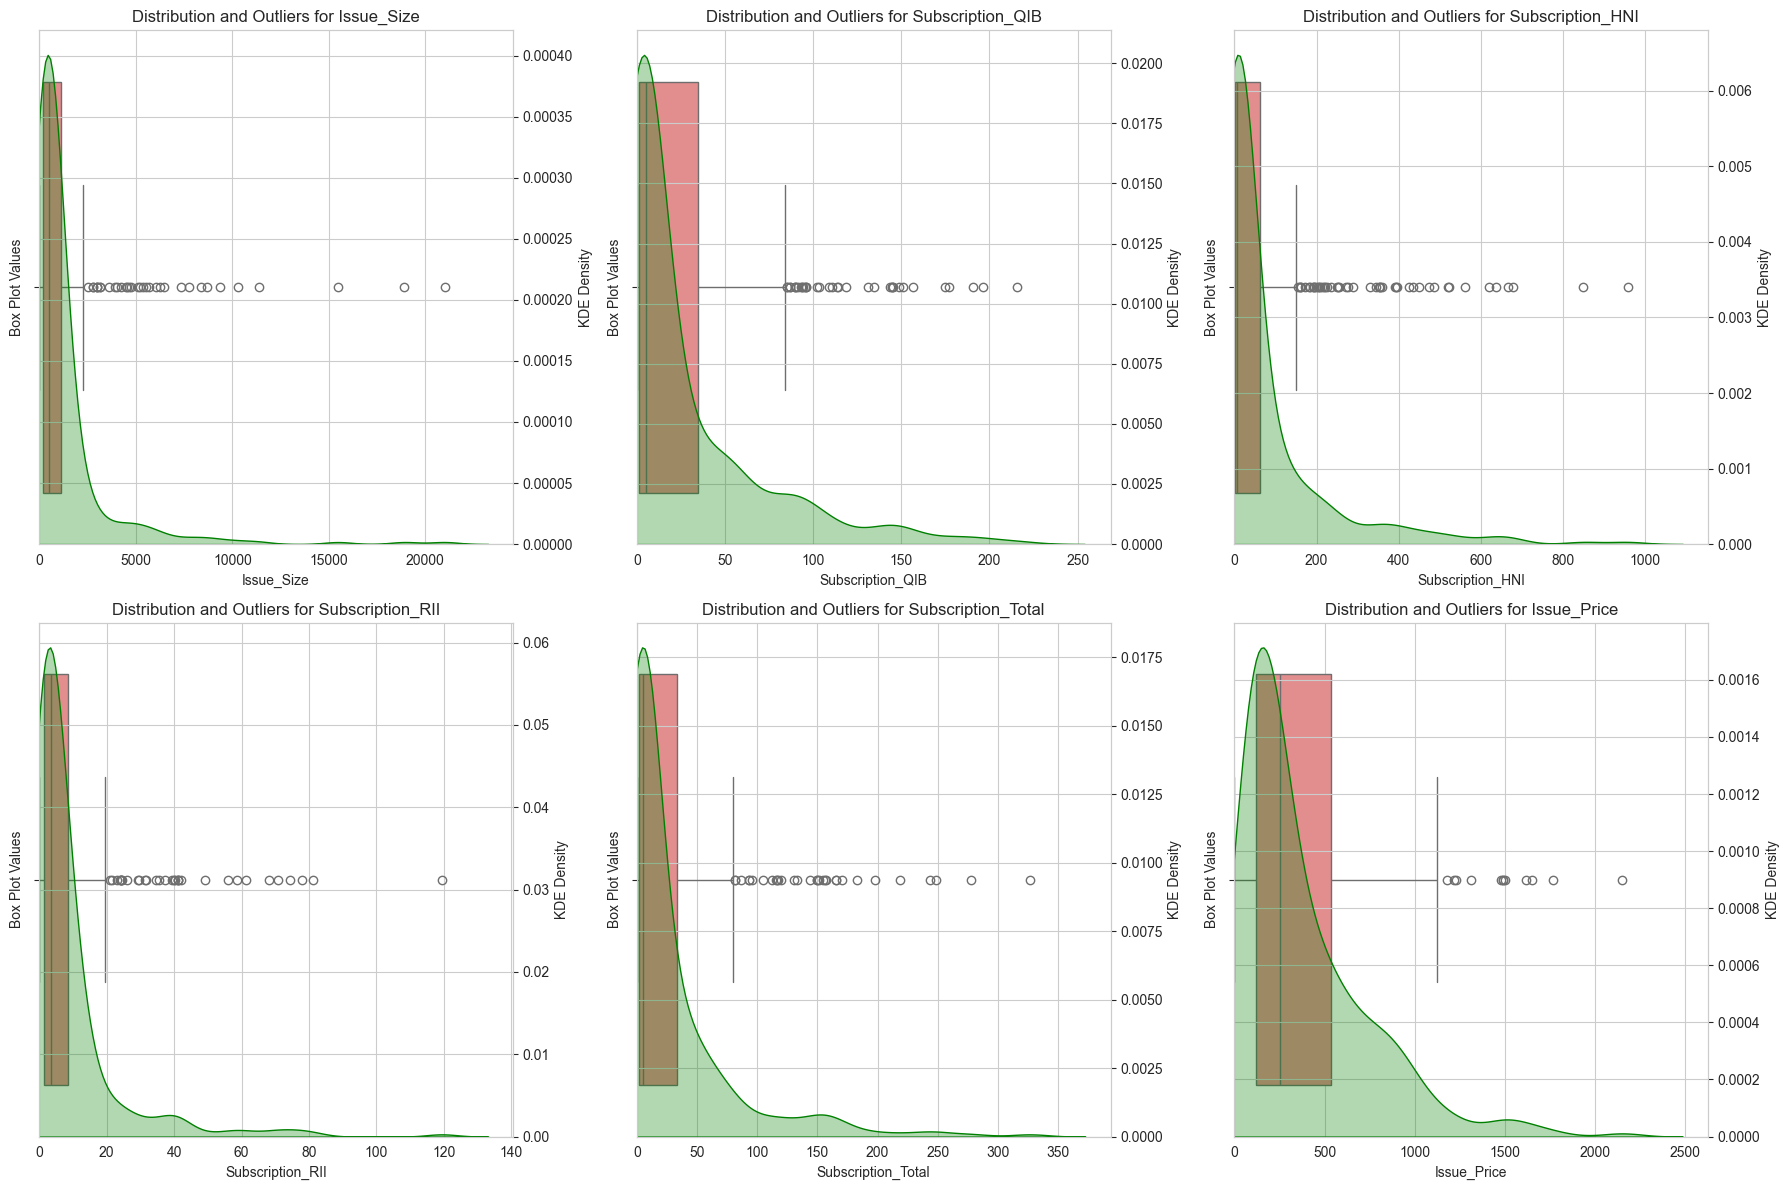

In [17]:
# Plot the distributions for Issue_Size, Subscription_QIB, Subscription_HNI, Subscription_RII, Subscription_Total, and Issue_Price, highlighting outliers
import math

columns_to_plot = ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total',
                   'Issue_Price']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 figure arrangement

for i, col in enumerate(columns_to_plot):
    ax = axes[math.floor(i / 3), i % 3]  # Determine subplot position
    sns.boxplot(data=ipo_data, x=col, color='lightcoral', ax=ax)  # Change box plot color

    # Add a secondary y-axis for KDE-based histogram
    kde_ax = ax.twinx()  # Create a twin y-axis for kde plot
    sns.kdeplot(data=ipo_data[col], fill=True, color='green', alpha=0.3, ax=kde_ax)
    kde_ax.set_ylabel("KDE Density")  # Label KDE axis

    ax.set_title(f'Distribution and Outliers for {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Box Plot Values')  # Label box plot axis

    # Truncate KDE plots at 0 on the x-axes
    ax.set_xlim(left=0)
    kde_ax.set_xlim(left=0)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

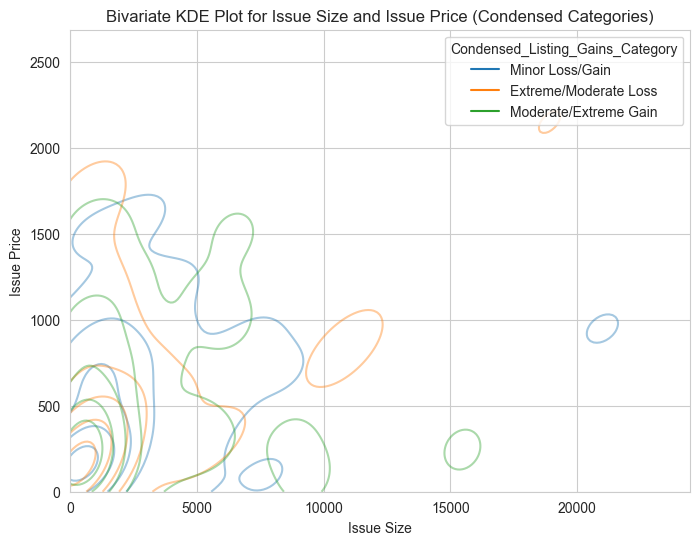

In [18]:
# Create a condensed column for Listing Gains Categories
condensed_categories = {
        'Extreme Loss' : 'Extreme/Moderate Loss',
        'Moderate Loss': 'Extreme/Moderate Loss',
        'Minor Loss'   : 'Minor Loss/Gain',
        'Minor Gain'   : 'Minor Loss/Gain',
        'Moderate Gain': 'Moderate/Extreme Gain',
        'Extreme Gain' : 'Moderate/Extreme Gain',
        'Zero'         : 'Minor Loss/Gain'  # Assuming 'Zero' falls into the middle category
}

ipo_data['Condensed_Listing_Gains_Category'] = ipo_data['Listing_Gains_Category'].map(condensed_categories)

# Create a bivariate KDE plot for Issue_Size and Issue_Price with hue based on the condensed categories
plt.figure(figsize=(8, 6))

sns.kdeplot(
    data=ipo_data,
    x='Issue_Size',
    y='Issue_Price',
    hue='Condensed_Listing_Gains_Category',  # Hue now uses condensed categories
    fill=False,
    alpha=0.4,  # Adjusted alpha for better transparency
    warn_singular=False,  #Silence warning for the zero column
    levels=6,  # Limits the number of contour levels to reduce overlap
    clip=(0, None)
)

plt.title('Bivariate KDE Plot for Issue Size and Issue Price (Condensed Categories)')
plt.xlabel('Issue Size')
plt.ylabel('Issue Price')

# # Truncate the plot at 0 on both axes
# plt.xlim(left=0)
# plt.ylim(bottom=0)

plt.show()

The visualisation of the different listing gains categories indicates they are centred around the same points, but
some of the outlier data indicates there might be a difference in the shapes of moderate to extreme gains vs losses
at higher issue sizes and prices.

# Data Cleaning
Based on visualization, we need to determine how to handle outliers, scale, and normalize each feature going into this model. Since most distributions are **right-skewed**, we apply transformations to stabilize variance and ensure better model performance.

| **Column Name**         | **Distribution** | **Outlier Handling**                               | **Scaling & Normalization**               |
|-------------------------|------------------|----------------------------------------------------|-------------------------------------------|
| `Date`                  | Categorical      | N/A                                                | Not required                              |
| `IPOName`               | Categorical      | N/A                                                | Not required                              |
| `Issue_Size`            | Right-skewed     | Log Transform + Robust Scaling                     | `log1p` + Robust Scaling                  |
| `Subscription_QIB`      | Right-skewed     | Log Transform + Clipping (1st & 99.5th percentile) | `log1p` + Robust Scaling                  |
| `Subscription_HNI`      | Right-skewed     | Log Transform + Clipping (1st & 99.5th percentile) | `log1p` + Robust Scaling                  |
| `Subscription_RII`      | Right-skewed     | Log Transform + Clipping (1st & 99.5th percentile) | `log1p` + Robust Scaling                  |
| `Subscription_Total`    | Right-skewed     | Log Transform + Clipping (1st & 99.5th percentile) | `log1p` + Robust Scaling                  |
| `Issue_Price`           | Right-skewed     | Log Transform + Robust Scaling                     | `log1p` + Robust Scaling                  |


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd


# Define a custom winsorization transformer using numpy.percentile
def winsorize_data(X):
    # Calculate the 1st and 99th percentiles for each column
    lower_bounds = np.percentile(X, 1, axis=0)
    upper_bounds = np.percentile(X, 99.5, axis=0)
    # Clip the values in each column based on the calculated percentiles
    return np.clip(X, lower_bounds, upper_bounds)


# Define the transformations for numerical features only
numerical_features = ["Issue_Size", "Subscription_QIB", "Subscription_HNI", "Subscription_RII", "Subscription_Total",
                      "Issue_Price"]

# Log transformation, winsorization, and scaling for numerical features
numerical_transformer = Pipeline(steps=[
        ("log_transform", FunctionTransformer(np.log1p, validate=True)),  # Apply log1p transformation
        ("winsorize", FunctionTransformer(winsorize_data, validate=False)),  # Apply winsorization
        ("scaler", RobustScaler())  # Apply RobustScaler
]
)

# Combine the transformations into a single pipeline (exclude categorical features)
preprocessor = ColumnTransformer(
    transformers=[
            ("num", numerical_transformer, numerical_features)
    ]
)

# Apply the transformations to the data and create the pipeline
transformed_data_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit and transform ipo_data
prepared_data_array = transformed_data_pipeline.fit_transform(ipo_data)

# Convert to DataFrame and retain column names for numerical features
prepared_data = pd.DataFrame(prepared_data_array, columns=numerical_features)

# Add the Listing_Gains_Category column to the prepared_data DataFrame
prepared_data["Listing_Gains_Category"] = ipo_data["Listing_Gains_Category"].values

# Output the transformed data and column information
print(f"Transformed data shape: {prepared_data.shape}")
print(prepared_data.head())

Transformed data shape: (319, 7)
   Issue_Size  Subscription_QIB  Subscription_HNI  Subscription_RII  \
0   -0.512732          0.754752          0.861322          0.697968   
1   -0.219954          0.826010          0.650117          0.055808   
2   -1.157107         -0.389503          0.319520          0.343539   
3   -0.485388         -0.366964         -0.079987         -0.696790   
4   -3.017425         -0.485466         -0.263860         -0.211327   

   Subscription_Total  Issue_Price Listing_Gains_Category  
0            0.783222    -0.275920             Minor Gain  
1            0.658473    -0.361593           Extreme Loss  
2            0.015466    -0.797278          Moderate Gain  
3           -0.383011    -0.275920          Moderate Loss  
4           -0.400979    -0.797278             Minor Loss  


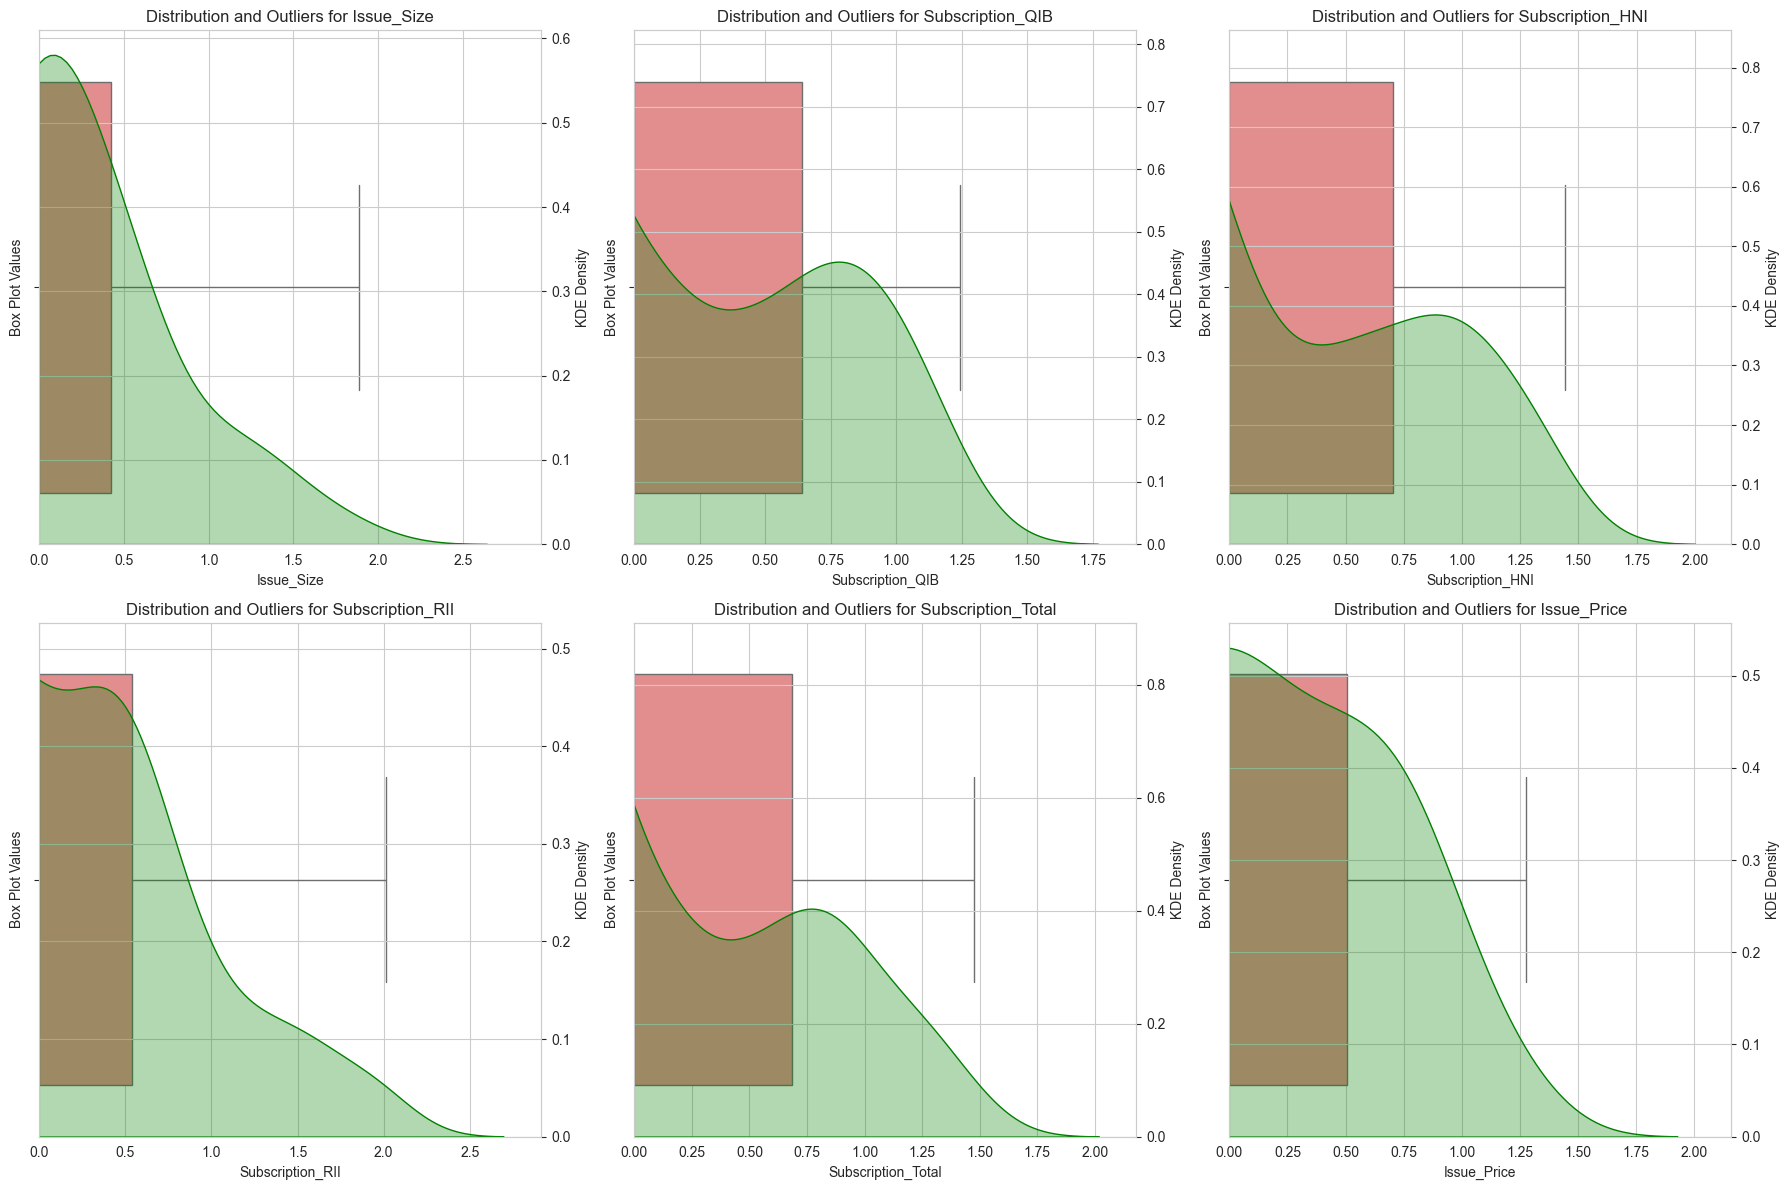

In [20]:
columns_to_plot = ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total',
                   'Issue_Price']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 figure arrangement

for i, col in enumerate(columns_to_plot):
    ax = axes[math.floor(i / 3), i % 3]  # Determine subplot position
    sns.boxplot(data=prepared_data, x=col, color='lightcoral', ax=ax)  # Change box plot color

    # Add a secondary y-axis for KDE-based histogram
    kde_ax = ax.twinx()  # Create a twin y-axis for kde plot
    sns.kdeplot(data=prepared_data[col], fill=True, color='green', alpha=0.3, ax=kde_ax)
    kde_ax.set_ylabel("KDE Density")  # Label KDE axis

    ax.set_title(f'Distribution and Outliers for {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Box Plot Values')  # Label box plot axis

    # Truncate KDE plots at 0 on the x-axes
    ax.set_xlim(left=0)
    kde_ax.set_xlim(left=0)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

The prepared data distributions seem more reasonable now. Now outliers, values fitting comfortably within ranges

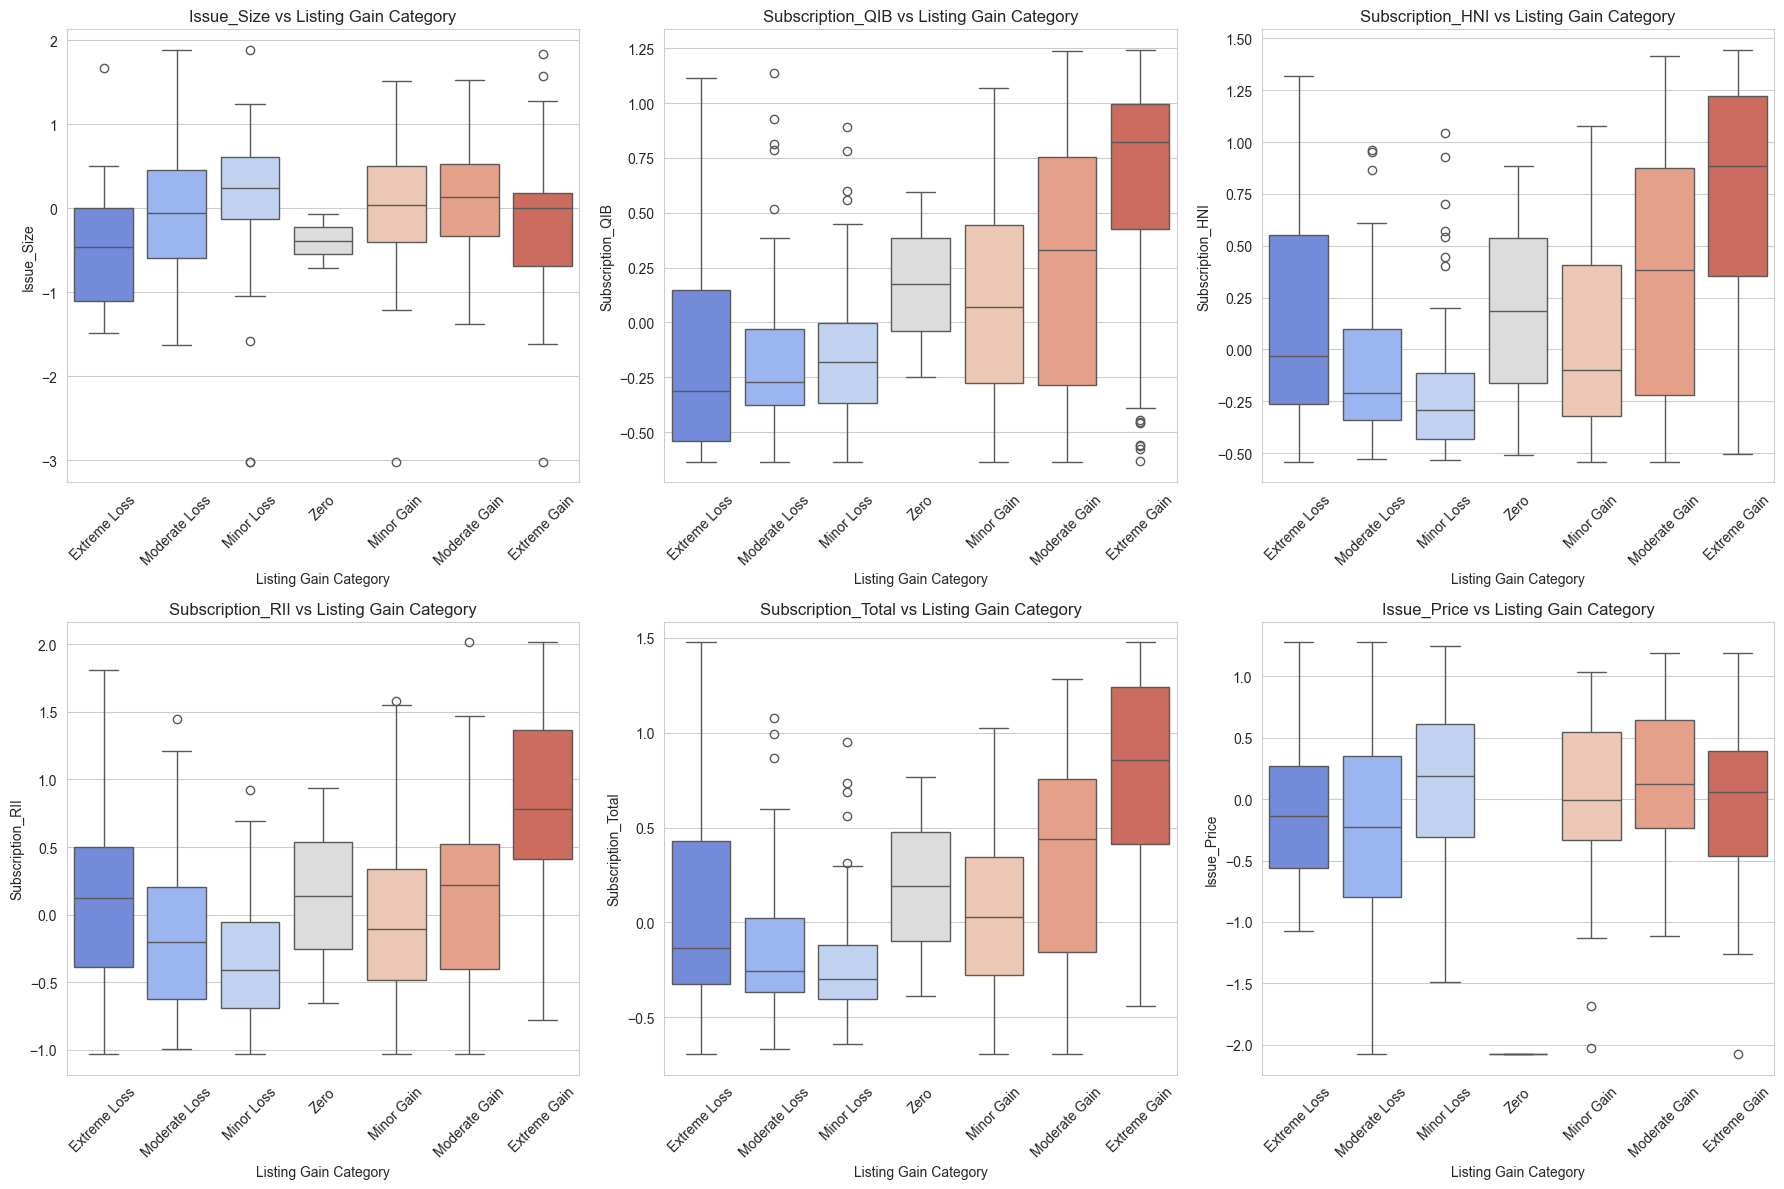

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create a 2x3 figure arrangement

# Flatten the axes array for easier subplot management
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    ax = axes[i]  # Access flattened subplot position
    sns.boxplot(data=prepared_data,
                x='Listing_Gains_Category',
                hue='Listing_Gains_Category',
                y=col,
                palette='coolwarm',
                ax=ax,
                legend=False
                )  # Pass ax explicitly to put the boxplot in the right subplot

    ax.set_title(f'{col} vs Listing Gain Category')
    ax.set_xlabel('Listing Gain Category')
    ax.set_ylabel(col)

    # Rotate x-axis labels to 45 degrees
    ax.tick_params(axis='x', rotation=45)

# Turn off any unused subplots (if the number of columns is less than 6)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

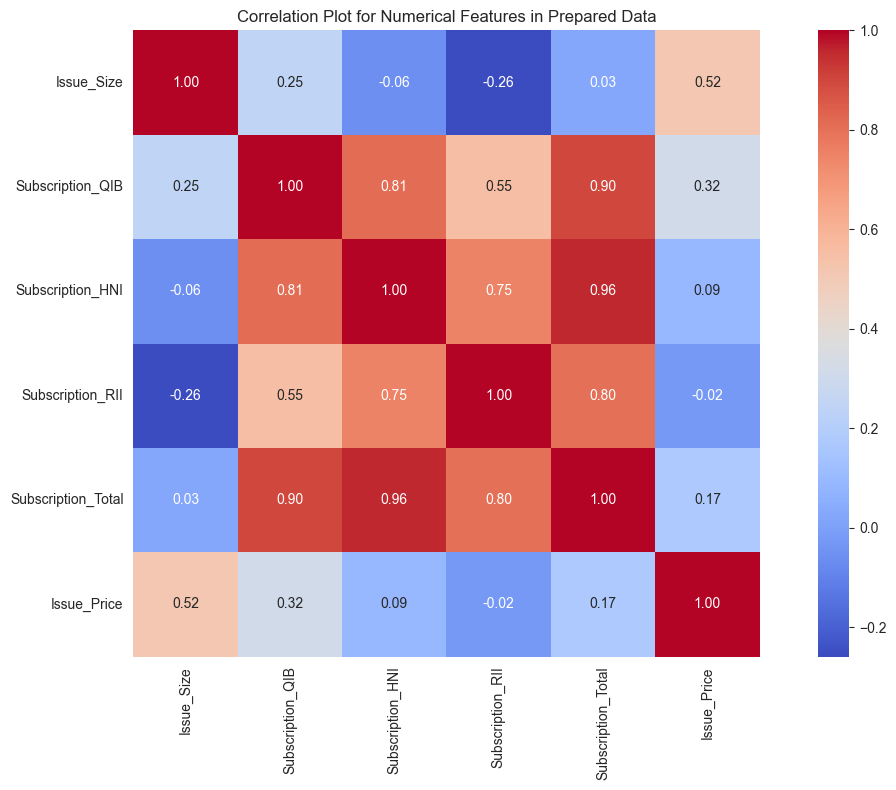

In [22]:
# Generate a correlation plot for the numerical features in prepared_data
numerical_features = prepared_data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
correlation_matrix = prepared_data[numerical_features].corr()

# Create a heatmap to visualize correlations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Plot for Numerical Features in Prepared Data")
plt.tight_layout()
plt.show()

As we'd expect there's a lot of strong correlation between the Subscription_Total and the QIB and HNI, with the RII
being lower. HNI and QIB often fly in the same social circles and have similar contacts and information sources. The
issue price and size and QIB being loosely correlated makes sense as well. IPOs are often coducted with the backing
and advice of financial experts from qualified institutions.

The data is ready to be fed into a model, we just need to split it and build the neural network


# Test training data split
Normally splitting data using `test_train_split` is fine, but in this case we want to build a model that can predict
the future, so we'll train it on some historical data and see how well it predicts future data.



In [23]:
# Rename the 'Date ' column to 'Date' to remove the whitespace
ipo_data.rename(columns={'Date ': 'Date'}, inplace=True)

# Convert the 'Date' column to a datetime object
ipo_data['Date'] = pd.to_datetime(ipo_data['Date'], format='%d/%m/%y', errors='coerce')

# Determine the split date to ensure 70% of data is for training
split_date = ipo_data['Date'].iloc[int(len(ipo_data) * 0.7)]

# Split the data based on the calculated split_date
training_data = ipo_data[ipo_data['Date'] < split_date]
testing_data = ipo_data[ipo_data['Date'] >= split_date]

print(f"Training data shape: {training_data.shape}")
print(f"Testing data shape: {testing_data.shape}")

Training data shape: (223, 12)
Testing data shape: (96, 12)


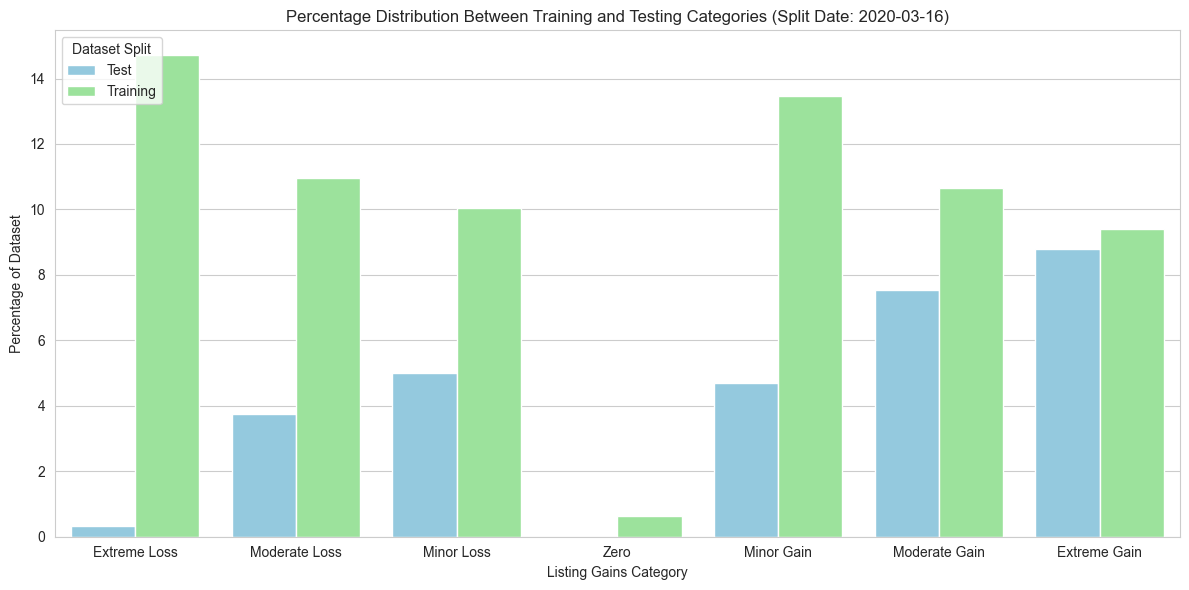

In [24]:
# Countplot of training and testing dataset categories
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use seaborn's countplot for visualization
sns.countplot(
    data=ipo_data,
    x="Listing_Gains_Category",
    hue=ipo_data["Date"] < split_date,
    palette=["skyblue", "lightgreen"],
    stat='percent',
    ax=ax1
)

# Update the legend labels to 'Test' and 'Training'
ax1.legend(
    title="Dataset Split",
    labels=["Test", "Training"],
    loc="upper left"
)

# Include the split date in the title
ax1.set_title(f"Percentage Distribution Between Training and Testing Categories (Split Date: {split_date.date()})")
ax1.set_xlabel("Listing Gains Category")
ax1.set_ylabel("Percentage of Dataset")

plt.tight_layout()
plt.show()

In [25]:
# Calculate positive and negative gains counts for training and testing datasets
positive_categories = ["Minor Gain", "Moderate Gain", "Extreme Gain"]
negative_categories = ["Extreme Loss", "Moderate Loss", "Minor Loss"]

# Calculate counts for training data
training_positive_count = training_data["Listing_Gains_Category"].isin(positive_categories).sum()
training_negative_count = training_data["Listing_Gains_Category"].isin(negative_categories).sum()

# Calculate counts for testing data
testing_positive_count = testing_data["Listing_Gains_Category"].isin(positive_categories).sum()
testing_negative_count = testing_data["Listing_Gains_Category"].isin(negative_categories).sum()

# Calculate ratios for training and testing datasets
training_ratio = f"{training_positive_count}:{training_negative_count}"
testing_ratio = f"{testing_positive_count}:{testing_negative_count}"

# Display the positive-to-negative gain ratios
print(f"Training Positive-to-Negative Gains Ratio: {training_ratio}")
print(f"Testing Positive-to-Negative Gains Ratio: {testing_ratio}")

Training Positive-to-Negative Gains Ratio: 107:114
Testing Positive-to-Negative Gains Ratio: 67:29


### Date split
Splitting by date, there's definitely some bias in the datasets. The training data set is 20% Extreme losses. Global
trends can take years, but still we care about predicting the future. So we'll see how the model goes. The dataset
download goes up to 2022, but if we need to we can scrape some more data for up to 2025. The data after the date
split is fairly positive. COVID had a significant impact around that split date.

### Distribution split
We can also split the data to try and mirror the distributions across both sets. We'll try this later if needed

# Building Neural Network
Now that we've got our data cleaned and split, it's time to construct a neural network. We'll start with input layer
to match our 6 features, and output layer will be 7, one for each category. We'll add a few hidden layers with
neurons and do some estimation of training time

In [26]:
# Define the neural network architecture

# Determine the split date for 70% training and 30% testing
split_date = ipo_data['Date'].quantile(0.7)  # Calculate the 70th percentile date

# Convert Date column to datetime
prepared_data['Date'] = pd.to_datetime(ipo_data['Date'])  # Ensure Date is in datetime format

# Use LabelEncoder to transform the Listing_Gains_Category
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
prepared_data['Listing_Gains_Category'] = label_encoder.fit_transform(prepared_data['Listing_Gains_Category'])

# Split the prepared_data into training and test based on the split_date
training_data = prepared_data[prepared_data['Date'] < split_date]
testing_data = prepared_data[prepared_data['Date'] >= split_date]

# Drop the 'Date' column from training and testing data
training_data = training_data.drop(columns=['Date'])
testing_data = testing_data.drop(columns=['Date'])

# Separate features and target variable for training and testing sets
x_train = training_data.drop(columns=['Listing_Gains_Category'])
y_train = training_data['Listing_Gains_Category']
x_test = testing_data.drop(columns=['Listing_Gains_Category'])
y_test = testing_data['Listing_Gains_Category']

In [246]:
from keras.initializers import HeNormal

model = keras.Sequential([
        layers.InputLayer(shape=(x_train.shape[1],)),
        layers.Dense(256, activation='relu', kernel_initializer=HeNormal()),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
]
)

# Display the model summary
model.summary()

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_170 (Dense)               │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,935 (175.53 KB)

 Trainable params: 44,167 (172.53 KB)

 Non-trainable params: 768 (3.00 KB)

In [241]:
# Define the custom Categorical Focal Loss
class CategoricalFocalLoss(keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        super(CategoricalFocalLoss, self).__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(
            y_pred, keras.backend.epsilon(), 1 - keras.backend.epsilon()
        )
        # Calculate cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred)
        # Apply focal loss scaling
        weights = self.alpha * tf.pow(1 - y_pred, self.gamma)
        focal_loss = weights * cross_entropy
        # Return the sum of the losses across classes
        return tf.reduce_sum(focal_loss, axis=-1)


model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=CategoricalFocalLoss(alpha=0.25, gamma=2.0),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],  # Fixed the issue here
)

tf.random.set_seed(42)

history = model.fit(
    x_train,
    y_train,
    epochs=750,
    batch_size=32,  # Default batch size; feel free to adjust as needed
    validation_split=0.2,  # Optional, adds validation data
    verbose=0  # Print training progress
)

In [242]:
model.evaluate(x_train, y_train)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.2088 - sparse_categorical_accuracy: 0.0022     


[6.193006992340088, 0.008968610316514969]

In [243]:
model.evaluate(x_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2482 - sparse_categorical_accuracy: 0.0000e+00 


[6.124406337738037, 0.0]

In [244]:
# Define the mapping of class indices to their names
class_names = ["Extreme Gain", "Moderate Gain", "Minor Gain", "Extreme Loss", "Moderate Loss", "Minor Loss", "Zero"]

# Evaluate the model on the training data
train_evaluation = model.evaluate(x_train, y_train, verbose=0)
print(f"Training Evaluation: {train_evaluation}")

# Evaluate the model on the test data
test_evaluation = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Evaluation: {test_evaluation}")

# Extract predictions for a few test samples
sample_indices = [0, 5, 10, 20, 25, 50]  # Example: Picking a few test sample indices (adjust as needed)
sample_features = x_test.iloc[sample_indices]
sample_actual_classes = y_test.iloc[sample_indices]

# Get model predictions (probabilities) for the selected samples
sample_predictions = model.predict(sample_features)

# Prepare data for a table
table_data = []

# Loop through each sample and format the data for display
for i, index in enumerate(sample_indices):
    actual_class_index = sample_actual_classes.iloc[i]
    actual_class_name = class_names[actual_class_index]
    predicted_probabilities = sample_predictions[i]
    ranked_predictions_indices = predicted_probabilities.argsort()[
                                 ::-1]  # Sort indices in descending order of probabilities

    ranked_predictions_names = [class_names[rank] for rank in ranked_predictions_indices]  # Get class names
    ranked_probabilities = [predicted_probabilities[rank] for rank in ranked_predictions_indices]

    # Add the data to the table
    table_data.append({
            "Sample Index"           : index,
            "Actual Class"           : actual_class_name,
            "Predicted Rankings"     : ", ".join(ranked_predictions_names),
            "Predicted Probabilities": ", ".join([f"{prob:.4f}" for prob in ranked_probabilities])
    }
    )

# Display as a table
import pandas as pd

results_table = pd.DataFrame(table_data)
display(results_table)

Training Evaluation: [6.193006992340088, 0.008968610316514969]
Test Evaluation: [6.124406337738037, 0.0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


,Sample Index,Actual Class,Predicted Rankings,Predicted Probabilities
0,0,Minor Loss,"Zero, Minor Loss, Moderate Loss, Extreme Gain,...","0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429..."
1,5,Moderate Loss,"Zero, Minor Loss, Moderate Loss, Extreme Gain,...","0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429..."
2,10,Moderate Loss,"Zero, Minor Loss, Moderate Loss, Extreme Gain,...","0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429..."
3,20,Moderate Loss,"Zero, Minor Loss, Moderate Loss, Extreme Gain,...","0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429..."
4,25,Extreme Loss,"Zero, Minor Loss, Moderate Loss, Extreme Gain,...","0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429..."
5,50,Minor Gain,"Zero, Minor Loss, Moderate Loss, Extreme Gain,...","0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429..."


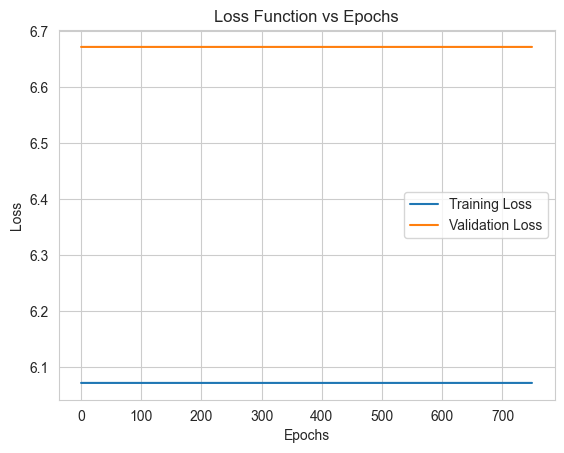

In [245]:
# Plot training and validation loss vs epochs for the model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Neural network evaluation
Splitting by date and 7 categories doesn't seem to yield a high result

In [230]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the neural network architecture
model2 = keras.Sequential([
        layers.InputLayer(shape=(x_train.shape[1],)),

        # First hidden layer
        layers.Dense(256),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),  # Dropout to reduce overfitting

        # Second hidden layer
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        # Third hidden layer
        layers.Dense(32),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Output layer: 7 nodes, one for each category
        layers.Dense(7, activation='softmax')  # Softmax for classification
]
)

# Compile the model with optimized loss and learning rate
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Explicit LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model2.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, mode='max', min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model with validation monitoring
history = model2.fit(
    x_train, y_train,
    validation_split=0.3,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_166 (Dense)               │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,959 (85.78 KB)

 Trainable params: 21,255 (83.03 KB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1515 - loss: 2.2495 - val_accuracy: 0.1493 - val_loss: 1.9509 - learning_rate: 1.0000e-04
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1282 - loss: 2.2083 - val_accuracy: 0.1343 - val_loss: 1.9449 - learning_rate: 1.0000e-04
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1675 - loss: 2.2149 - val_accuracy: 0.1642 - val_loss: 1.9383 - learning_rate: 1.0000e-04
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1704 - loss: 2.1405 - val_accuracy: 0.1791 - val_loss: 1.9306 - learning_rate: 1.0000e-04
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1623 - loss: 2.1344 - val_accuracy: 0.2090 - val_loss: 1.9243 - learning_rate: 1.0000e-04
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2328 - loss: 2.0757 - val_accuracy: 0.2239 - val_loss: 1.9186 - learning_rate: 1.0000e-04
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2246 - loss:

In [231]:
model2.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_166 (Dense)               │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,471 (251.84 KB)

 Trainable params: 21,255 (83.03 KB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 42,512 (166.07 KB)

In [232]:
model2.evaluate(x_train, y_train)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2697 - loss: 1.8718 


[1.8623849153518677, 0.2959641218185425]

In [233]:
model2.evaluate(x_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2786 - loss: 1.8632 


[1.8636565208435059, 0.2604166567325592]